# Conservation Analysis of Genomic Features

This notebook analyzes conservation patterns in alternative transcript regions using PhyloCSF and PhyloP scores. The analysis pipeline is designed to handle multiple types of genomic features:
- N-terminal extensions (NTEs)
- C-terminal extensions (CTEs)
- Intronic regions

## Setup
First, we'll import required libraries and set up our basic configuration. We use:
- `polars` for efficient data manipulation
- `pyranges` for genomic interval operations
- `pyBigWig` for accessing conservation scores
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization

In [2]:
# Standard libraries
from pathlib import Path
import sys
from typing import List, Optional, Dict, Tuple
from datetime import datetime

# Add project root to Python path for imports
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom utilities
from src.utils import ConservationTracker, ConservationAnalyzer, BEDHandler

# Data handling
import polars as pl
import numpy as np
import pyranges as pr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()
sns.set_context("notebook")

## Configuration

Set up paths and parameters for the analysis. This notebook is configured for N-terminal extensions (NTEs), but the same structure can be used for CTEs and intronic regions by modifying these parameters.

Key parameters:
- Feature type (NTE/CTE/intronic)
- Input paths for feature data, annotations, and conservation scores
- Analysis parameters like window size
- Output directory structure

In [5]:
# Define feature type
FEATURE_TYPE = "NTE"  # One of: "NTE", "CTE", "INTRONIC"

# Set up directory structure
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results" / FEATURE_TYPE.lower()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Input paths
feature_path = DATA_DIR / "raw" / "NTEs.bed12"
gencode_path = DATA_DIR / "raw" / "gencode.v47.annotation.gtf"
phylocsf_dir = DATA_DIR / "raw" / "phylocsf"
phylop_path = DATA_DIR / "raw" / "phyloP" / "PhyloP_470way.bw"

# Analysis parameters
WINDOW_SIZE = 30  # Size of sliding window for conservation analysis
MIN_REGION_SIZE = 10  # Minimum size of region to analyze
SCORE_THRESHOLD = 0  # Threshold for calling positive conservation

# Initialize our utility classes
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)
bed_handler = BEDHandler()

# Verify paths exist
for path in [feature_path, gencode_path, phylocsf_dir, phylop_path]:
    if not path.exists():
        raise FileNotFoundError(f"Required file/directory not found: {path}")

print("Configuration complete. Analysis will use:")
print(f"- Feature type: {FEATURE_TYPE}")
print(f"- Feature data: {feature_path}")
print(f"- Results directory: {RESULTS_DIR}")

Configuration complete. Analysis will use:
- Feature type: NTE
- Feature data: ../data/raw/NTEs.bed12
- Results directory: ../results/nte


## Data Loading and Preprocessing

Load our N-terminal extension data from the BED12 file and prepare it for analysis. Steps include:
1. Load the BED12 file using our custom handler
2. Extract transcript IDs from feature names
3. Basic QC checks on the loaded data
4. Display summary statistics of our features

Loading feature data...

Feature Statistics:
Total features loaded: 20372

Chromosome distribution:
shape: (24, 2)
┌───────┬───────┐
│ chrom ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 1864  │
│ 10    ┆ 667   │
│ 11    ┆ 1373  │
│ 12    ┆ 1215  │
│ 13    ┆ 284   │
│ …     ┆ …     │
│ 7     ┆ 980   │
│ 8     ┆ 722   │
│ 9     ┆ 630   │
│ X     ┆ 825   │
│ Y     ┆ 1     │
└───────┴───────┘

Strand distribution:
shape: (2, 2)
┌────────┬───────┐
│ strand ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ +      ┆ 10673 │
│ -      ┆ 9699  │
└────────┴───────┘

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 20372.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 43146.989594  │
│ std        ┆ 79477.093943  │
│ min        ┆ 30.0          │
│ 25%        ┆ 6787.0        │
│ 50%        ┆ 1

/tmp/ipykernel_1585214/2832992967.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
/tmp/ipykernel_1585214/2832992967.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("strand").agg(pl.count()))


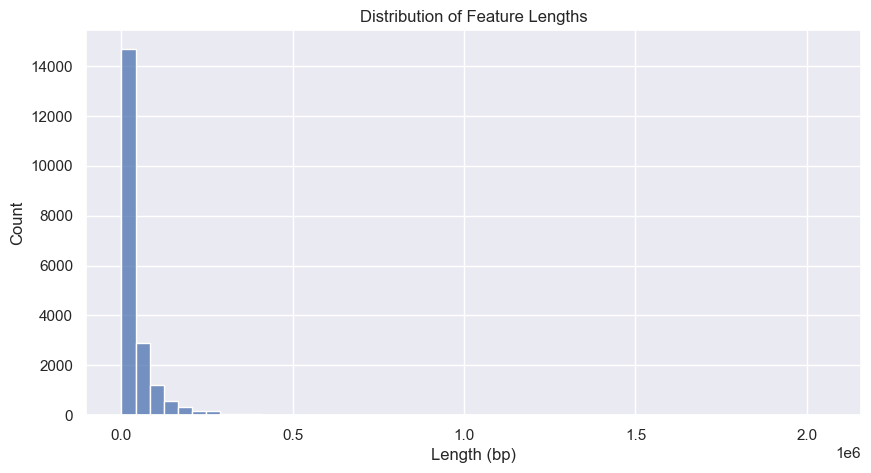


Data loading and preprocessing complete.


In [6]:
# Load feature data using our BED handler
print("Loading feature data...")
feature_df = bed_handler.load_bed12(feature_path)

# Extract transcript IDs from names and add region length
feature_df = feature_df.with_columns([
    # Extract transcript ID from feature name (assumes format: ENST00000123456_...)
    pl.col("name").str.split("_").list.first().alias("transcript_id"),
    
    # Calculate region length
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
])

# Print basic statistics
print("\nFeature Statistics:")
print(f"Total features loaded: {len(feature_df)}")
print("\nChromosome distribution:")
print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
print("\nStrand distribution:")
print(feature_df.group_by("strand").agg(pl.count()))
print("\nLength statistics:")
print(feature_df.select("region_length").describe())

# Quick length distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data=feature_df.to_pandas(), x="region_length", bins=50)
plt.title("Distribution of Feature Lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

print("\nData loading and preprocessing complete.")

## Extension Region Identification

Before calculating conservation scores, we need to precisely identify the extension regions by:
1. Loading CDS annotations from GENCODE
2. Identifying the correct CDS start/end positions
3. Determining the extension coordinates based on strand orientation:
   - For + strand: region between chromStart and CDS start
   - For - strand: region between CDS end and chromEnd
4. Validating extension regions

In [7]:
# Load GENCODE annotation
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)
cds_annotation = gr[gr.Feature == "CDS"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")

# Convert pyranges to polars for joining with normalized chromosome names
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "chrom": [str(x).replace('chr', '') for x in cds_annotation.Chromosome.to_list()],
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})

# Get correct CDS positions based on strand
cds_regions = (cds_df
    .group_by("transcript_id")
    .agg([
        pl.col("strand").first().alias("strand"),
        pl.col("gene_name").first(),
        pl.col("cds_frame").first().alias("cds_frame"),
        # Get correct single position based on strand
        pl.when(pl.col("strand").first() == "+")
        .then(pl.min("cds_start"))  
        .otherwise(pl.max("cds_end"))  
        .alias("cds_start_pos")
    ]))

# Join with features and identify extension regions
feature_df = (feature_df
    .with_columns(
        pl.col("name").str.split("_").list.first().alias("transcript_id")
    )
    .join(
        cds_regions.select([
            "transcript_id", 
            "strand",
            "gene_name",
            "cds_frame",
            "cds_start_pos"
        ]), 
        on="transcript_id", 
        how="left",
        suffix="_cds"
    ))

# Print some validations
print("\nValidated extension regions:")
print(feature_df.head())

Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47

Validated extension regions:
shape: (5, 18)
┌───────┬────────────┬──────────┬────────────┬───┬────────────┬───────────┬───────────┬────────────┐
│ chrom ┆ chromStart ┆ chromEnd ┆ name       ┆ … ┆ strand_cds ┆ gene_name ┆ cds_frame ┆ cds_start_ │
│ ---   ┆ ---        ┆ ---      ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ pos        │
│ str   ┆ i64        ┆ i64      ┆ str        ┆   ┆ str        ┆ str       ┆ str       ┆ ---        │
│       ┆            ┆          ┆            ┆   ┆            ┆           ┆           ┆ i64        │
╞═══════╪════════════╪══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪════════════╡
│ 1     ┆ 924053     ┆ 944153   ┆ ENST000006 ┆ … ┆ +          ┆ SAMD11    ┆ 0         ┆ 924431     │
│       ┆            ┆          ┆ 16016      ┆   ┆            ┆           ┆           ┆            │
│ 1     ┆ 924053     ┆ 944153   ┆ ENST000006 ┆ … ┆ +          ┆ SAMD11   

## Conservation Score Calculation

Calculate both PhyloCSF and PhyloP conservation scores for extension regions using our utility classes. For each region we:
1. Use `ConservationTracker` to access scores
2. Calculate metrics using `ConservationAnalyzer`
3. Store results in a properly structured DataFrame

In [8]:
# Initialize conservation trackers
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)

def calculate_extension_frame(ext_length: int, cds_frame: int, strand: str) -> int:
    """
    Calculate the correct reading frame for the extension.
    
    Args:
        ext_length: Length of the extension
        cds_frame: Frame of the CDS (0, 1, or 2)
        strand: '+' or '-'
    
    Returns:
        Correct PhyloCSF frame (1, 2, or 3)
    """
    if strand == '+':
        # For + strand, we count backwards from CDS start
        offset = (3 - (ext_length % 3) + cds_frame) % 3
    else:
        # For - strand, we count forward from CDS end
        offset = (ext_length % 3 + cds_frame) % 3
    
    # Convert to PhyloCSF frame numbering (1-based)
    return offset + 1

def calculate_all_scores(nte_df, conservation_tracker, conservation_analyzer):
    """Calculate detailed conservation metrics for NTEs"""
    from time import time
    import numpy as np
    
    # Initialize lists for all our metrics
    metrics_lists = {
        'matched_frame_score': [],  # Score in the frame matching CDS
        'max_frame_score': [],      # Best frame score (for comparison)
        'start_region_score': [],   # First 15bp conservation
        'window_max_score': [],     # Best 30bp window
        'phylop_mean': [],          # Overall conservation
        'extension_frame': [],      # Calculated correct frame
        'extension_length': []
    }
    
    total_features = len(nte_df)
    processed = 0
    
    for row in nte_df.iter_rows(named=True):
        if processed % 100 == 0:
            print(f"Processed {processed}/{total_features} features "
                  f"({processed/total_features*100:.1f}%)")
        
        processed += 1
        
        # Initialize default values
        current_metrics = {key: None for key in metrics_lists.keys()}
        
        if row['cds_start_pos'] and row['cds_frame'] is not None:
            # Determine extension coordinates
            if row['strand'] == '+':
                ext_start = row['chromStart']
                ext_end = row['cds_start_pos']
            else:
                ext_start = row['cds_start_pos']
                ext_end = row['chromEnd']
                
            if ext_start >= ext_end:
                for key in metrics_lists:
                    metrics_lists[key].append(None)
                continue
                
            try:
                # Calculate extension length and correct frame
                ext_length = ext_end - ext_start
                correct_frame = calculate_extension_frame(
                    ext_length, 
                    int(row['cds_frame']), 
                    row['strand']
                )
                current_metrics['extension_length'] = ext_length
                current_metrics['extension_frame'] = correct_frame
                
                # Get conservation scores
                phylocsf_scores, phylop_scores = conservation_tracker.get_conservation_scores(
                    row['chrom'],
                    ext_start,
                    ext_end,
                    row['strand']
                )
                
                if phylocsf_scores:
                    # Calculate frame-specific scores
                    frame_means = {
                        frame: np.nanmean(scores) if len(scores) > 0 else np.nan 
                        for frame, scores in phylocsf_scores.items()
                    }
                    
                    # Score in matching frame
                    current_metrics['matched_frame_score'] = frame_means.get(correct_frame)
                    
                    # Max frame score (for comparison)
                    current_metrics['max_frame_score'] = max(frame_means.values())
                    
                    # Start region analysis (first 15bp)
                    start_scores = phylocsf_scores[correct_frame][:15]
                    if len(start_scores) > 0:
                        current_metrics['start_region_score'] = float(np.nanmean(start_scores))
                    
                    # Sliding window analysis (30bp)
                    window_size = 30
                    scores = phylocsf_scores[correct_frame]
                    if len(scores) >= window_size:
                        windows = [
                            np.nanmean(scores[i:i+window_size])
                            for i in range(len(scores) - window_size + 1)
                        ]
                        current_metrics['window_max_score'] = float(max(windows))
                
                if phylop_scores is not None:
                    current_metrics['phylop_mean'] = float(np.nanmean(phylop_scores))
                
            except Exception as e:
                print(f"Error processing feature {row['transcript_id']}: {str(e)}")
        
        # Add all metrics to their respective lists
        for key in metrics_lists:
            metrics_lists[key].append(current_metrics[key])
    
    # Add all metrics to DataFrame
    return nte_df.with_columns([
        pl.Series(name, values) for name, values in metrics_lists.items()
    ])

print("Calculating conservation scores...")
nte_df_with_scores = calculate_all_scores(feature_df, conservation_tracker, conservation_analyzer)

# Add genome coordinates for reference
nte_df_with_scores = nte_df_with_scores.with_columns(
   (pl.col("chrom") + ":" + 
    pl.col("chromStart").cast(pl.Utf8) + "-" +
    pl.col("cds_start_pos").cast(pl.Utf8)
   ).alias("genome_coords")
)

# Show results
print("\nSample of scored regions:")
print(nte_df_with_scores.select([
   "transcript_id",
   "gene_name",
   "genome_coords",
   "matched_frame_score",
   "max_frame_score",
   "start_region_score",
   "window_max_score",
   "phylop_mean",
   "extension_frame",
   "extension_length"
]).head())

# Basic statistics
print("\nScore statistics:")
score_columns = [
    "matched_frame_score",
    "max_frame_score",
    "start_region_score",
    "window_max_score",
    "phylop_mean",
    "extension_length"
]

for col in score_columns:
    print(f"\n{col}:")
    print(nte_df_with_scores.select(pl.col(col)).describe())

Calculating conservation scores...
Processed 0/20372 features (0.0%)


/tmp/ipykernel_1585214/2942631345.py:112: RuntimeWarning: Mean of empty slice
  np.nanmean(scores[i:i+window_size])
/tmp/ipykernel_1585214/2942631345.py:92: RuntimeWarning: Mean of empty slice
  frame: np.nanmean(scores) if len(scores) > 0 else np.nan
/tmp/ipykernel_1585214/2942631345.py:105: RuntimeWarning: Mean of empty slice
  current_metrics['start_region_score'] = float(np.nanmean(start_scores))


Processed 100/20372 features (0.5%)
Processed 200/20372 features (1.0%)
Processed 300/20372 features (1.5%)
Processed 400/20372 features (2.0%)
Processed 500/20372 features (2.5%)
Processed 600/20372 features (2.9%)
Processed 700/20372 features (3.4%)
Processed 800/20372 features (3.9%)
Processed 900/20372 features (4.4%)
Processed 1000/20372 features (4.9%)
Processed 1100/20372 features (5.4%)
Processed 1200/20372 features (5.9%)
Processed 1300/20372 features (6.4%)
Processed 1400/20372 features (6.9%)
Processed 1500/20372 features (7.4%)
Processed 1600/20372 features (7.9%)
Processed 1700/20372 features (8.3%)
Processed 1800/20372 features (8.8%)
Processed 1900/20372 features (9.3%)
Processed 2000/20372 features (9.8%)
Processed 2100/20372 features (10.3%)
Processed 2200/20372 features (10.8%)
Processed 2300/20372 features (11.3%)
Processed 2400/20372 features (11.8%)
Processed 2500/20372 features (12.3%)
Processed 2600/20372 features (12.8%)
Processed 2700/20372 features (13.3%)
Pro

/tmp/ipykernel_1585214/2942631345.py:118: RuntimeWarning: Mean of empty slice
  current_metrics['phylop_mean'] = float(np.nanmean(phylop_scores))


Processed 16400/20372 features (80.5%)
Processed 16500/20372 features (81.0%)
Processed 16600/20372 features (81.5%)
Processed 16700/20372 features (82.0%)
Processed 16800/20372 features (82.5%)
Processed 16900/20372 features (83.0%)
Processed 17000/20372 features (83.4%)
Processed 17100/20372 features (83.9%)
Processed 17200/20372 features (84.4%)
Processed 17300/20372 features (84.9%)
Processed 17400/20372 features (85.4%)
Processed 17500/20372 features (85.9%)
Processed 17600/20372 features (86.4%)
Processed 17700/20372 features (86.9%)
Processed 17800/20372 features (87.4%)
Processed 17900/20372 features (87.9%)
Processed 18000/20372 features (88.4%)
Processed 18100/20372 features (88.8%)
Processed 18200/20372 features (89.3%)
Processed 18300/20372 features (89.8%)
Processed 18400/20372 features (90.3%)
Processed 18500/20372 features (90.8%)
Processed 18600/20372 features (91.3%)
Processed 18700/20372 features (91.8%)
Processed 18800/20372 features (92.3%)
Processed 18900/20372 fea

## High-Confidence Extension Analysis

Filter and categorize the extensions based on conservation scores:
1. Filter for positive PhyloCSF scores (indicating coding potential)
2. Sort by conservation strength
3. Separate novel vs. overlapping extensions
4. Generate visualizations and summary statistics


Score statistics for all NTEs:
shape: (10, 9)
┌────────────┬───────────┬────────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ transcript ┆ gene_name ┆ genome_coo ┆ strand ┆ … ┆ max_frame ┆ start_reg ┆ window_ma ┆ extension │
│ _id        ┆ ---       ┆ rds        ┆ ---    ┆   ┆ _score    ┆ ion_score ┆ x_score   ┆ _frame    │
│ ---        ┆ str       ┆ ---        ┆ str    ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆           ┆ str        ┆        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64       │
╞════════════╪═══════════╪════════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ENST000006 ┆ SAMD11    ┆ 1:924053-9 ┆ +      ┆ … ┆ -10.18945 ┆ -14.4392  ┆ 2.2537    ┆ 1         │
│ 16016      ┆           ┆ 24431      ┆        ┆   ┆           ┆           ┆           ┆           │
│ ENST000006 ┆ SAMD11    ┆ 1:924053-9 ┆ +      ┆ … ┆ -10.18945 ┆ -14.4392  ┆ 2.2537    ┆ 1         │
│ 18323      ┆           ┆ 24431      ┆     

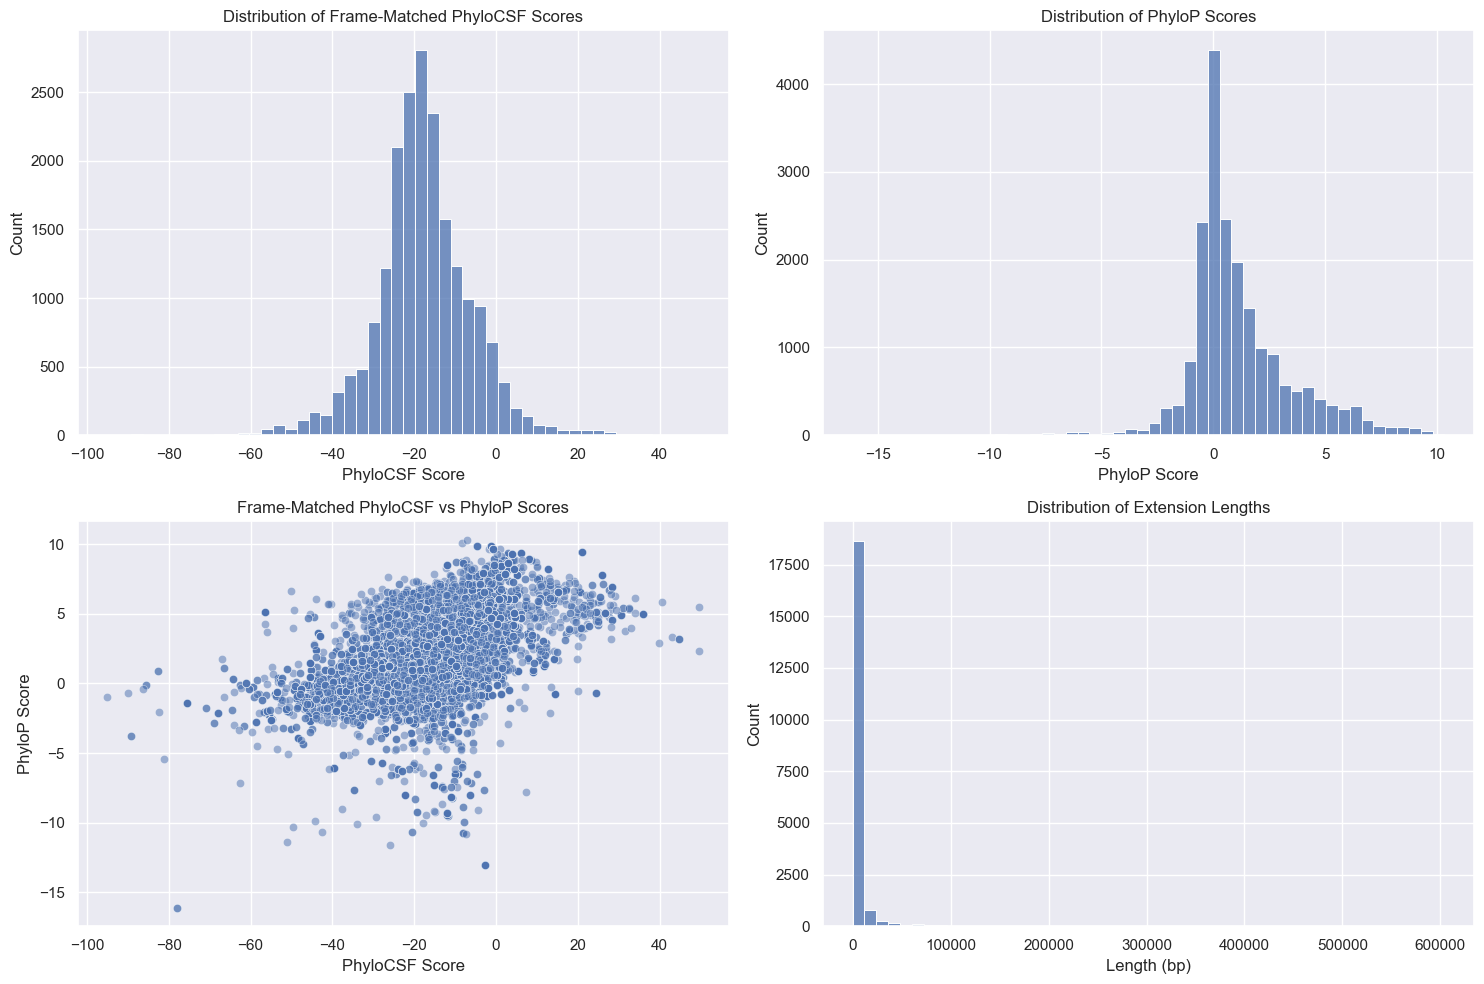

NameError: name 'date_str' is not defined

In [9]:
# Show distribution of all scores
print("\nScore statistics for all NTEs:")
print(nte_df_with_scores.select([
   "transcript_id",
   "gene_name",
   "genome_coords", 
   "strand",
   "matched_frame_score",
   "max_frame_score",
   "start_region_score",
   "window_max_score",
   "extension_frame"
]).head(10))

# Create visualization of score distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Matched frame scores distribution
sns.histplot(
    data=nte_df_with_scores.to_pandas(), 
    x="matched_frame_score",
    bins=50,
    ax=axes[0]
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")

# PhyloP score distribution
sns.histplot(
    data=nte_df_with_scores.to_pandas(), 
    x="phylop_mean",
    bins=50,
    ax=axes[1]
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")

# PhyloCSF vs PhyloP
sns.scatterplot(
    data=nte_df_with_scores.to_pandas(),
    x="matched_frame_score",
    y="phylop_mean",
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")

# Extension lengths
sns.histplot(
    data=nte_df_with_scores.to_pandas(),
    x="extension_length",
    bins=50,
    ax=axes[3]
)
axes[3].set_title("Distribution of Extension Lengths")
axes[3].set_xlabel("Length (bp)")

plt.tight_layout()
plt.show()

def write_scored_bed(df, score_col, output_path, scale_factor=1000):
    """Write BED file with specified score column in proper BED format"""
    
    # Create a simpler version
    bed_df = (df
        # First handle the score calculation and coordinates
        .with_columns([
            # Add 'chr' prefix to chrom
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            
            # Handle start/end coordinates ensuring start <= end
            pl.when(pl.col("chromStart") > pl.col("cds_start_pos"))
            .then(pl.col("cds_start_pos"))
            .otherwise(pl.col("chromStart"))
            .alias("start"),
            
            pl.when(pl.col("chromStart") > pl.col("cds_start_pos"))
            .then(pl.col("chromStart"))
            .otherwise(pl.col("cds_start_pos"))
            .alias("end"),
            
            # Handle the score
            pl.when(pl.col(score_col).is_null() | pl.col(score_col).is_nan())
            .then(0)
            .otherwise(
                ((pl.col(score_col) - pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) / 
                 (pl.col(score_col).filter(~pl.col(score_col).is_nan()).max() - 
                  pl.col(score_col).filter(~pl.col(score_col).is_nan()).min()) * scale_factor)
            )
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)
            .alias("bed_score")
        ])
        # Select and reorder columns for BED format
        .select([
            "chr_name",
            "start",
            "end",
            "transcript_id",
            "bed_score",
            "strand"
        ])
        # Filter out invalid entries
        .filter(
            (pl.col("start").is_not_null()) &
            (pl.col("end").is_not_null())
        ))
    
    # Write the BED file
    bed_df.write_csv(
        output_path, 
        separator="\t", 
        include_header=False
    )
    
    print(f"Wrote {len(bed_df)} entries to {output_path}")
    print("\nFirst few lines of BED file:")
    print(bed_df.head())
# Write a proper BED file with scores



# Regenerate BED files
for score_type, column in {
    "matched_frame": "matched_frame_score",
    "phylop": "phylop_mean",
    "window_max": "window_max_score"
}.items():
    output_path = RESULTS_DIR / "bed" / f"nte_{score_type}_{date_str}.bed"
    print(f"\nWriting {score_type} BED file...")
    write_scored_bed(nte_df_with_scores, column, output_path)

# Print some diagnostics before writing
print("\nScore column statistics:")
for col in ["matched_frame_score", "phylop_mean", "window_max_score"]:
    print(f"\n{col}:")
    print(f"Total values: {len(nte_df_with_scores)}")
    print(f"Null values: {nte_df_with_scores.filter(pl.col(col).is_null()).height}")
    print(f"NaN values: {nte_df_with_scores.filter(pl.col(col).is_nan()).height}")
    print(f"Negative values: {nte_df_with_scores.filter(pl.col(col) < 0).height}")
    print("Overall statistics:")
    print(nte_df_with_scores.select(pl.col(col)).describe())


## Finding Novel Extension Regions

After calculating conservation scores for all potential N-terminal extensions, we need to identify which ones are truly novel (i.e., don't overlap with known coding sequences in other transcripts). This requires:

1. Prerequisites:
  - Bedtools installed (`conda install -c bioconda bedtools`)
  - Our scored BED files from the conservation analysis
  - GENCODE v47 CDS annotations in BED format

2. Steps to identify novel extensions:

```bash
# First convert GENCODE GTF CDS regions to BED
# If using UCSC genome browser coordinates (our case):
awk '$3=="CDS" {print $1"\t"$4-1"\t"$5}' data/raw/gencode.v47.annotation.gtf > gencode.v47.cds.bed

# Use bedtools intersect to find non-overlapping regions
# For matched frame scores:
bedtools intersect -v -a nte_matched_frame_20241031.bed -b gencode.v47.cds.bed > novel_nte_matched_frame.bed

# For PhyloP scores:
bedtools intersect -v -a nte_phylop_20241031.bed -b gencode.v47.cds.bed > novel_nte_phylop.bed

# For window max scores:
bedtools intersect -v -a nte_window_max_20241031.bed -b gencode.v47.cds.bed > novel_nte_window_max.bed

## Results Output Organization

We should save both figures and data files for reproducibility and future reference. Here's what we should output:

### Figures
1. **Distribution Plots** (`results/nte/figures/`)
  - Score distributions:
    ```python
    # Distribution plots (4-panel)
    fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.pdf")
    fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.png", dpi=300)
    ```

2. **Correlation Plots**
  - PhyloCSF vs PhyloP
  - Score vs length relationships
  - Separate plots for clarity

### Tables/Data Files 
1. **Summary Statistics** (`results/nte/tables/`)


In [ ]:
# Create directory structure
RESULTS_DIR = Path("../results/nte")
for subdir in ["figures", "tables", "bed"]:
    (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)

# Get current date for file naming
date_str = datetime.now().strftime("%Y%m%d")

# Save figures
plt.figure(figsize=(15, 10))
# Distribution plots (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# Matched frame scores distribution
sns.histplot(
    data=nte_df_with_scores.to_pandas(), 
    x="matched_frame_score",
    bins=50,
    ax=axes[0]
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")

# PhyloP score distribution
sns.histplot(
    data=nte_df_with_scores.to_pandas(), 
    x="phylop_mean",
    bins=50,
    ax=axes[1]
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")

# PhyloCSF vs PhyloP
sns.scatterplot(
    data=nte_df_with_scores.to_pandas(),
    x="matched_frame_score",
    y="phylop_mean",
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("Frame-Matched PhyloCSF vs PhyloP Scores")
axes[2].set_xlabel("PhyloCSF Score")
axes[2].set_ylabel("PhyloP Score")

# Extension lengths
sns.histplot(
    data=nte_df_with_scores.to_pandas(),
    x="extension_length",
    bins=50,
    ax=axes[3]
)
axes[3].set_title("Distribution of Extension Lengths")
axes[3].set_xlabel("Length (bp)")

plt.tight_layout()

# Save the figure
fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.pdf")
fig.savefig(RESULTS_DIR / "figures" / f"nte_score_distributions_{date_str}.png", dpi=300)

# Save summary statistics
metrics = [
    "matched_frame_score",
    "max_frame_score",
    "start_region_score",
    "window_max_score",
    "phylop_mean",
    "extension_length"
]

summary_stats = nte_df_with_scores.select(metrics).describe()
summary_stats.write_csv(RESULTS_DIR / "tables" / f"nte_summary_stats_{date_str}.tsv", separator="\t")

# Save full results
nte_df_with_scores.write_csv(RESULTS_DIR / "tables" / f"nte_full_results_{date_str}.tsv", separator="\t")

# Save high-confidence results
high_conf = nte_df_with_scores.filter(
    (pl.col("matched_frame_score") > 10) &
    (pl.col("phylop_mean") > 2)
)
high_conf.write_csv(RESULTS_DIR / "tables" / f"nte_high_confidence_{date_str}.tsv", separator="\t")

# Save BED files
for score_type, column in {
    "matched_frame": "matched_frame_score",
    "phylop": "phylop_mean",
    "window_max": "window_max_score"
}.items():
    output_path = RESULTS_DIR / "bed" / f"nte_{score_type}_{date_str}.bed"
    write_scored_bed(nte_df_with_scores, column, output_path)

print("Results saved in:")
print(f"- Figures: {RESULTS_DIR}/figures/")
print(f"- Tables: {RESULTS_DIR}/tables/")
print(f"- BED files: {RESULTS_DIR}/bed/")

In [1]:
nte_df_with_scores

NameError: name 'nte_df_with_scores' is not defined